In [2]:
# Import required packages
%matplotlib inline
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import h5py
import xarray as xr

## load in data

In [3]:
os.chdir('/tmp')

if not os.path.exists('/tmp/polygons'):
        os.makedirs('/tmp/polygons')

os.chdir('/tmp/mintpy')

Place json with areas of interest or stable reference areas in polyons folder

In [69]:
# load in time series data 
disp_fn = '/tmp/mintpy/geo/geo_timeseries_ERA5_ramp_demErr.h5'
disp_df = xr.open_dataset(disp_fn, engine='h5netcdf', phony_dims='sort', decode_coords="all")

In [70]:
# examine structure
##### CURRENTLY BROKEN ########
# MintPy outputs H5 files, and the coordinates and dates don't survive being loaded into xarray
disp_df 

<xarray.Dataset>
Dimensions:     (phony_dim_0: 98, phony_dim_1: 450, phony_dim_2: 600)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    bperp       (phony_dim_0) float32 ...
    date        (phony_dim_0) |S8 ...
    timeseries  (phony_dim_0, phony_dim_1, phony_dim_2) float32 ...
Attributes: (12/113)
    ALOOKS:                                    5
    ANTENNA_SIDE:                              -1
    AZIMUTH_PIXEL_SIZE:                        78.08212603857966
    BANDS:                                     2
    CENTER_LINE_UTC:                           42584.0
    DATA_TYPE:                                 float32
    ...                                        ...
    stopUTC:                                   2014-12-13 11:50:07.299273
    swathNumber:                               12
    trackNumber:                               128
    width:                                     600
    xmax:                                      1670.0
    xmin:                                      1070.0

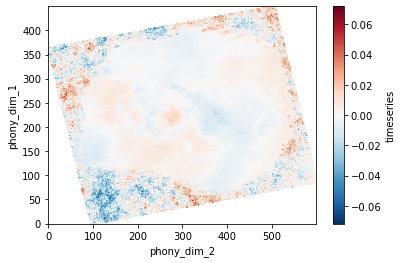

In [72]:
disp_df.isel(phony_dim_0=7).timeseries.plot.imshow()

In [20]:
disp_df.rio.crs = 'epsg:4326'

AttributeError: can't set attribute

In [19]:
# reproject to utm
disp_utm = disp_df.rio.reproject(disp_df.rio.estimate_utm_crs())
disp_utm.rio.crs

RuntimeError: crs must be set to estimate UTM CRS.

In [73]:
# load in average velocity
vel_fn = '/tmp/mintpy/geo/geo_velocity.h5'
vel_df = xr.open_dataset(vel_fn, engine='h5netcdf', decode_coords="all")

ValueError: variable '/velocity' has no dimension scale associated with axis 0. 
Use phony_dims='sort' for sorted naming or phony_dims='access' for per access naming.

In [ ]:
#examine structure
vel_df

In [ ]:
# reproject to utm
vel_utm = vel_df.rio.reproject(vel_df.rio.estimate_utm_crs())
vel_utm.rio.crs

In [ ]:
# load json of aoi 
aoi_fn = '/tmp/polygons/crater.geojson'
aoi_gdf = gpd.read_file(aoi_fn)

#reproject to match time series
aoi = aoi_gdf.to_crs(disp_utm.rio.crs)

#extract geometry to use for clipping
aoi_geom = aoi.iloc[0].geometry

In [ ]:
# load json of stable reference areas
ref_fn = '/tmp/polygons/stable.geojson'
ref_gdf = gpd.read_file(ref_fn)

#reproject to match time series
ref = ref_gdf.to_crs(disp_utm.rio.crs)

#extract geometry to use for clipping
ref_geom = ref.geometry

## Displacement and velocity of aoi

In [ ]:
disp_aoi = disp_utm['VARIABLE'].rio.clip(aoi_geom, crs=aoi.crs, drop=False)

In [ ]:
f, ax = plt.subplots(figsize=(7,5))
disp_aoi.mean(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='mean', c='gray')
disp_aoi.median(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='median', c='k')
disp_aoi.max(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='max', c='c', alpha=0.5)
disp_aoi.min(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='min', c='r', alpha=0.5)
ax.set_title('Mean cumulative displacement in aoi')
ax.set_yaxis('displacement (cm)')
ax.set_xaxis('time')

In [ ]:
vel_aoi = vel_utm['VARIABLE'].rio.clip(aoi_geom, crs=aoi.crs, drop=False)

In [ ]:
## going to need to work this out

f, ax = plt.subplots(figsize=(7,5))
ax.boxplot(disp_aoi(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax)
ax.set_title('Mean cumulative displacement in aoi')
ax.set_yaxis('velocity (cm/yr)')
ax.set_xaxis('time')

## Uncertainty of displacement and velocity

In [ ]:
disp_ref = disp_utm['VARIABLE'].rio.clip(ref_geom, crs=ref.crs, drop=False)

In [ ]:
f, ax = plt.subplots(figsize=(7,5))
disp_aoi.mean(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='mean', c='gray')
disp_aoi.median(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='median', c='k')
disp_aoi.max(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='max', c='c', alpha=0.5)
disp_aoi.min(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='min', c='r', alpha=0.5)
disp_aoi.median(dim=('latitude', 'longitude')).VARIABLE.plot(ax=ax, label='min', c='orange')
ax.set_title('Mean cumulative displacement in aoi')
ax.set_yaxis('displacement (cm)')
ax.set_xaxis('time')

## Change reference points 

In [ ]:
## gonna need to figure this out
def change_ref(xarray, lat, lon):
    #project coordinates
    transformer = Transformer.from_crs("EPSG:4326", xarray.rio.crs, always_xy=True)
    xx, yy = transformer.transform(lon, lat)
    
    # get value from grid
    value = xarray.sel(x=xx, y=yy, method="nearest").values
    
    for i in range(len()):
        xarray.isel(time=i)['VARIABLE'] -= xarray.sel(x=xx, y=yy, method="nearest").values